# Project: EDA on Medical Appointments Data of Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This dataset contains information from 100k medical appointments in Brazil and a outcome categorical variable indicating whether or not the patients showed up for their scheduled appointment. The goal was to explore the data and determine if there were any important factors that could tell us which patients were more likely to show up, or not show up, for their scheduled appointment. Specifically, we were interested in exploring how no-show rate aws related to:

- gender
- day of the week of the appointment
- number of days appointment is made in advance
- age
- degree of handicap

and whether the patients:
- received medical welfare
- were diagnosed with hypertension, diabetes, or alcoholism
- received SMS notification before the appointment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

First, we import the data and read the first 5 rows to get a sense of what the data looks like.

In [2]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


And checking the number of unique values for each column (mainly to confirm the factors are binary or not, like Gender):

In [3]:
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

Note that there are only 27 unique appointment day. Checking the min and max date:

In [4]:
print(df.AppointmentDay.min())
print(df.AppointmentDay.max())

2016-04-29T00:00:00Z
2016-06-08T00:00:00Z


It reveals that the observations were only collected in the span of 2 months, from end of April to early June. In other words, all conclusions/observations made in this EDA can only be said about these 2 months.

The column names are self explanatory. Here is a brief descirption of each column:

* PatientId - Unique ID for each patient
* AppointmentID - Unique ID for each appointment.
* Gender - Male/Female
* ScheduledDay - The day the patient makes the appointment.
* AppointmnetDay - The day the appointment is scheduled.
* Age - Age of the patient
* Neighborhood - The location of the hospital.
* Scholarship - whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.
* Hipertension - Whether or not the patient has hypertension.
* Diabetes - Whether or not the patient has diabetes.
* Alcholism - Whether or not the patient has alchol-related issues.
* Handcap - Rating from 0 - 4. Could be the level of handicapped.
* SMS_received - Whether or not the patient receives an SMS before the appointment.
* No-show - Whether the patient shows up or not. 1 indicates no-show.

Next, we check for missing data:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


Good news we don't have to deal with any missing data. Next, we check for the distributions of `Age` to determine whethere there are any aberrant records.

Before we move on to conducting further analyses, we notice that there is a typo and some inconsistency with some of the column names. Let's fix them first.

In [6]:
#Convert column names to lower case
df.columns = df.columns.str.lower()
#Fix typo and hyphen to underscore
df.rename(index = str, columns = {'hipertension' : 'hypertension', 'no-show':'no_show'}, inplace = True)

In [7]:
df.age.describe()

count    110527.000000
mean         37.088874
std          23.110205
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: age, dtype: float64

The max age of 115 is a bit surprising, but shouldn't be a big problem. However, the -1 could mean it's actually a missing value. A further look into `Age`:

In [8]:
#5 lowest values
df.age.value_counts().sort_index().head()

-1       1
 0    3539
 1    2273
 2    1618
 3    1513
Name: age, dtype: int64

Age of 0 can still be interepted as an infant who's below 1 year old. Age of -1 definitely signals missing value. Since there are over 100,000 observations in this dataset, it should be safe to remove this dubious observation entirely from the analysis.

In [9]:
#Drop the observation of -1 age
df.drop(df.query('age == -1').index, inplace = True)

Next, we check the distribution of age.

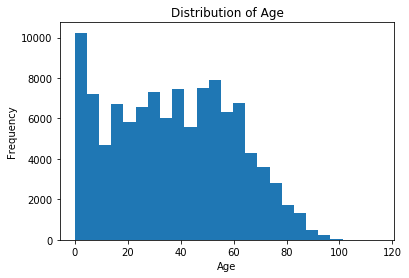

In [10]:
plt.hist(df.age, bins = 25);
plt.title('Distribution of Age');
plt.xlabel('Age');
plt.ylabel('Frequency');

Age is heavily skewed to the right. It makes sense that there are fewer people with age above 80, but simply regarding them as outliers is not justified as they are valid observations. Instead, we create a new categorical variable, `age_group`, that bins age in every increment of 10, and every person whose age is above 80 is grouped in the same category. Of course, ther are many other ways to to recode age into different categories. 

In [11]:
#define age_group function
def age_group(x):
    """Convert age into one of the age categories.

    Arguments:
    x(int) -- age
    
    Return:
    A string represents the age category.
    """
    if x <= 9:
        return('Below 10')
    elif x <= 19:
        return('10 - 19')
    elif x <= 29:
        return('20 - 29')
    elif x <= 39:
        return('30 - 39')
    elif x <= 49:
        return('40 - 49')
    elif x <= 59:
        return('50 - 59')
    elif x <= 69:
        return('60 - 69')
    elif x <= 79:
        return('70 - 79')
    else:
        return('80 or above')
    
df['age_group'] = df.age.apply(age_group)

#Factorize age_group
df['age_group'] = df['age_group'].astype('category')

#Reorder factor levels
df['age_group'].cat.reorder_categories(['Below 10', '10 - 19', '20 - 29', '30 - 39', '40 - 49', '50 - 59', '60 - 69', '70 - 79',\
                                       '80 or above'], inplace = True)

Checking the distribution of age_group:

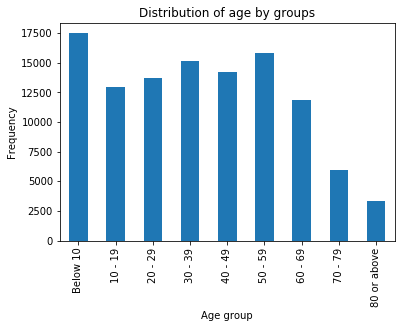

In [12]:
df.age_group.value_counts().sort_index().plot(kind = 'bar');
plt.title('Distribution of age by groups');
plt.xlabel('Age group');
plt.ylabel('Frequency');

Although it doesn't really solve the nonnormality of age, at least we are able to group the observations with extreme high age into the same category. 

### Data Cleaning (Replace this with more specific notes!)

Next, we need to parse the two columns related to day into datetime. They are now stored as string.

In [13]:
#Parse columns into datetime
df.scheduledday = pd.to_datetime(df.scheduledday)
df.appointmentday = pd.to_datetime(df.appointmentday)
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handcap,sms_received,no_show,age_group
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,60 - 69
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,50 - 59
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,60 - 69
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Below 10
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,50 - 59


Notice that `Appointment Day` does not contain the information of the actual time of the appointment, which could be a critical missing piece of information. Nonetheless, we can still look at the relationships between no-show and day of the week. A new predictor, `appointment_weekday`, is created:

In [14]:
#get weekday from appointment_weekday
df['appointment_weekday'] = df.appointmentday.dt.strftime('%A')

Next, it might be interesting to see if people who call to make the appointment a few days in advance are more likely to not show up for the appointment. A predictor, `days_in_advance`, is created:

In [15]:
#Remove the hour-minute-second from scheduledday
df.scheduledday = df.scheduledday.dt.strftime('%Y-%m-%d')
df.scheduledday = pd.to_datetime(df.scheduledday)
#get difference in days
df['days_in_advance'] = df.appointmentday - df.scheduledday
#extract number of days from timediff object
df.days_in_advance = df.days_in_advance.dt.days

Take a quick look of the newly created column:

In [16]:
df.days_in_advance.value_counts()

 0      38562
 2       6725
 4       5290
 1       5213
 7       4906
 6       4037
 5       3277
 14      2913
 3       2737
 8       2332
 21      1861
 28      1706
 13      1682
 9       1605
 15      1503
 10      1391
 20      1187
 22      1173
 16      1151
 12      1115
 17      1107
 29      1089
 19      1044
 18      1021
 27      1013
 11       987
 35       963
 23       822
 34       808
 26       731
        ...  
 98         5
 112        5
 103        5
 109        5
 108        5
 102        4
-1          4
 105        4
 96         4
 119        4
 122        3
 92         3
 115        2
 93         2
 110        2
 107        2
 97         2
 94         2
 123        1
 101        1
 126        1
 125        1
 139        1
 151        1
 132        1
 117        1
 146        1
 82         1
-6          1
 127        1
Name: days_in_advance, Length: 131, dtype: int64

We can notice a few rare observations with negative numbers! Let's count how many of these strange observations we have:

In [17]:
(df.days_in_advance < 0).sum()

5

Since there are only 5, out of the over 100,000 valid observations, again, we just simply drop these negative days.

In [18]:
df.drop(df[df.days_in_advance < 0].index, inplace = True)

Look at the distribution of days_in_advance:

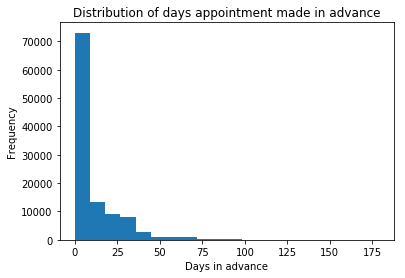

In [19]:
plt.hist(df.days_in_advance, bins = 20);
plt.title('Distribution of days appointment made in advance');
plt.xlabel('Days in advance');
plt.ylabel('Frequency');

It makes sense most appointments are made on the same day or just one or two days before. For those that are made over a month in advance, it is not uncommon but because of the relatively few observations, again we create categorical variables to bin the days into groups:

In [20]:
#define age_group function
def days_advance_group(x):
    """Convert days_in_advance into one of the categories.

    Arguments:
    x(int) -- days_in_advance
    
    Return:
    A string represents the category.
    """
    if x == 0:
        return('Same day')
    elif x <= 2:
        return('1 - 2 days')
    elif x <= 7:
        return('3 - 7 days')
    elif x <= 28:
        return('1 - 4 weeks')
    elif x <= 42:
        return('5 - 6 weeks')
    elif x <= 56:
        return('7 - 8 weeks')
    else:
        return('More than 2 months')
    
df['days_advance_group'] = df.age.apply(days_advance_group)

#Factorize age_group
df['days_advance_group'] = df['days_advance_group'].astype('category')

#Reorder factor levelsdays_advance_group
df['days_advance_group'].cat.reorder_categories(['Same day', '1 - 2 days', '3 - 7 days', '1 - 4 weeks',\
                                                 '5 - 6 weeks', '7 - 8 weeks', 'More than 2 months'],\
                                                inplace = True)

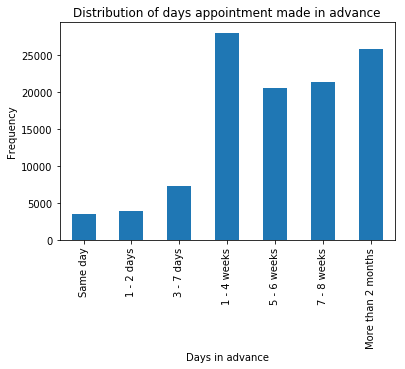

In [21]:
df.days_advance_group.value_counts().sort_index().plot(kind = 'bar');
plt.title('Distribution of days appointment made in advance');
plt.xlabel('Days in advance');
plt.ylabel('Frequency');

Finally, we need to convert `No` and `Yes` to `0` and `1` for `No-show`

In [22]:
df['no_show'] = df['no_show'].apply(lambda x: 0 if x == 'No' else 1)

<a id='eda'></a>
## Exploratory Data Analysis


### Research Question 1: Do men or women tend to not show up for the scheduled appointment?

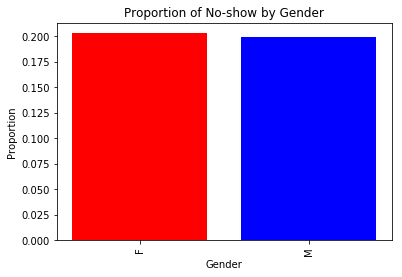

In [23]:
df_gender = df.groupby('gender')['no_show'].mean()
plt.bar([1,2], df_gender.values, color = ['red','blue'])
plt.xticks([1,2], df_gender.index, rotation='vertical');
plt.title('Proportion of No-show by Gender');
plt.xlabel('Gender');
plt.ylabel('Proportion');

The bar chart shows that there is no large difference between males and females in the no-show rate.

### Research Question 2: Are the no-show rates higher no the weekdays or weekends?

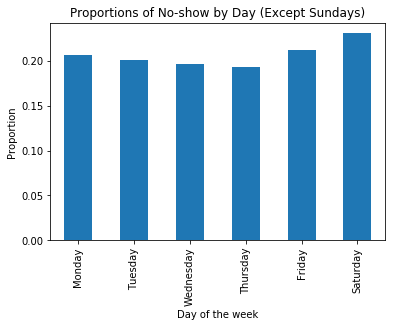

In [24]:
df_weekday = df.groupby('appointment_weekday')['no_show'].mean()
weekday_labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
df_weekday = df_weekday[weekday_labels]
df_weekday.plot(kind = 'bar')
plt.title('Proportions of No-show by Day (Except Sundays)');
plt.xlabel('Day of the week');
plt.ylabel('Proportion');

The chart suggests there is a slightly higher rate of no-shows on Fridays and especially on Saturdays.

### Research Question 3: Are the no-show rates higher if the appointments are made more days in advance?

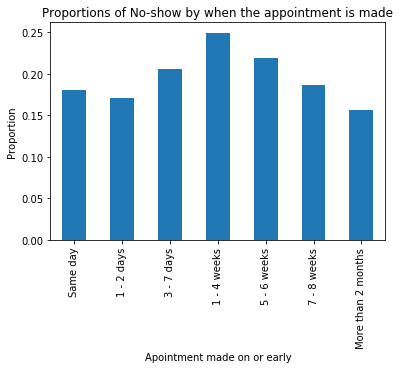

In [25]:
df_advance = df.groupby('days_advance_group')['no_show'].mean()
df_advance.plot(kind = 'bar');
plt.title('Proportions of No-show by when the appointment is made');
plt.xlabel('Apointment made on or early');
plt.ylabel('Proportion');

Those who make the appointment 1 to 6 weeks in advance seem to have the a relatively higher no-show rate.

### Research Question 4: How do no-show rates change with age?

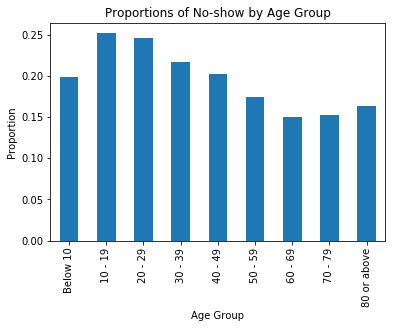

In [26]:
df_age = df.groupby('age_group')['no_show'].mean()
df_age.plot(kind = 'bar')
plt.title('Proportions of No-show by Age Group');
plt.xlabel('Age Group');
plt.ylabel('Proportion');

In [27]:
df_age_male = df.query('gender == "M"')
df_age_male = df_age_male.groupby('age_group')['no_show'].mean()

df_age_female = df.query('gender == "F"')
df_age_female = df_age_female.groupby('age_group')['no_show'].mean()

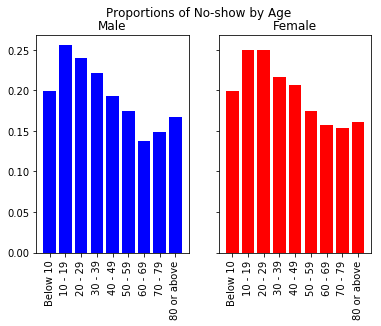

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.bar(range(len(df_age_male.index)), df_age_male.values, color = 'blue')
plt.sca(ax1)
plt.title('Male');
plt.xticks(range(len(df_age_male.index)), df_age_male.index, rotation = 90)
ax2.bar(range(len(df_age_female.index)), df_age_female.values, color = 'red')
plt.sca(ax2)
plt.title('Female');
plt.xticks(range(len(df_age_female.index)), df_age_female.index, rotation = 90)
f.suptitle('Proportions of No-show by Age');

The boxplots for overall no-show rates by age and the sepeate plots for each gender show similar trends. There is a peak at age around 15-20. Again, the high peaks on the right aren't representative because there are only a few observations in those age range.

### Research Question 4: Relationshop of Scholarship, Hipertension, Diabetes, Alcoholism, Handcap and SMS_received with No-show rate.

In the final part, we explore the relationships between the remaining predictors and no-show.

Those who are enrolled in the welfare program seems to have a higher no-show rate.

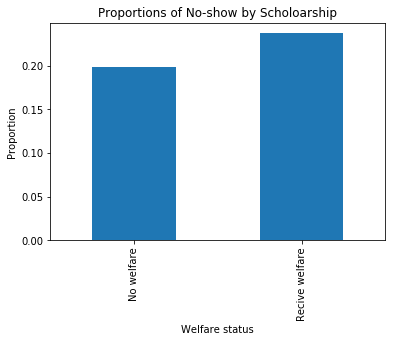

In [29]:
df.groupby('scholarship')['no_show'].mean().plot(kind = 'bar')
plt.title('Proportions of No-show by Scholoarship');
plt.xticks([0,1],['No welfare', 'Recive welfare']);
plt.xlabel('Welfare status');
plt.ylabel('Proportion');

Patients without hypertension have a higher no-show rate.

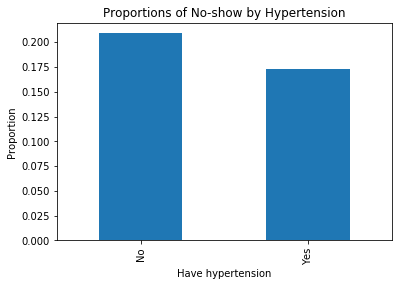

In [30]:
df.groupby('hypertension')['no_show'].mean().plot(kind = 'bar')
plt.title('Proportions of No-show by Hypertension');
plt.xticks([0,1],['No','Yes']);
plt.xlabel('Have hypertension');
plt.ylabel('Proportion');

Patients without diabetes have a higher no-show rate.

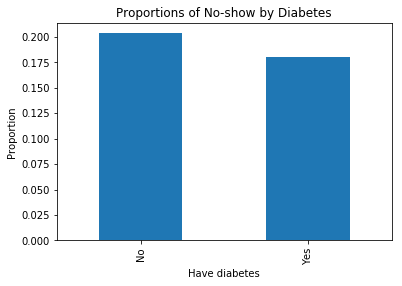

In [31]:
df.groupby('diabetes')['no_show'].mean().plot(kind = 'bar')
plt.title('Proportions of No-show by Diabetes');
plt.xticks([0,1],['No','Yes']);
plt.xlabel('Have diabetes');
plt.ylabel('Proportion');

No observable difference between alcoholic and non-alcoholic patients.

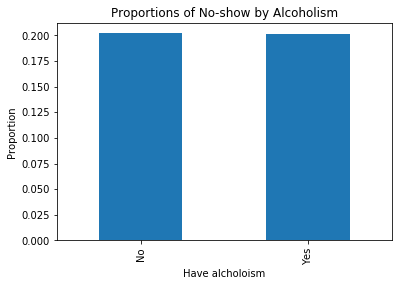

In [32]:
df.groupby('alcoholism')['no_show'].mean().plot(kind = 'bar')
plt.title('Proportions of No-show by Alcoholism');
plt.xticks([0,1],['No','Yes']);
plt.xlabel('Have alcholoism');
plt.ylabel('Proportion');

The no-show rates tend to increase with the handicapped rating.

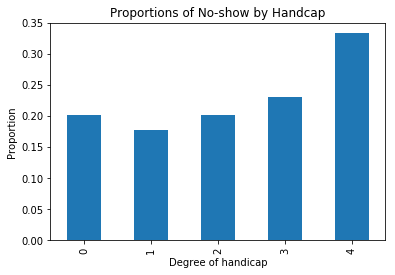

In [33]:
df.groupby('handcap')['no_show'].mean().plot(kind = 'bar')
plt.title('Proportions of No-show by Handcap');
plt.xlabel('Degree of handicap');
plt.ylabel('Proportion');

Interesting, those who received SMS tend to have a higher no-show rates.

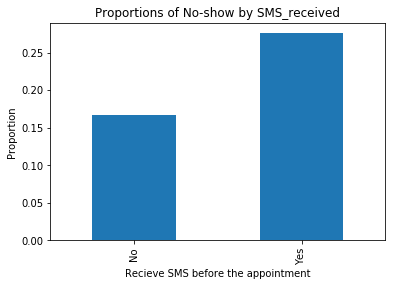

In [34]:
df.groupby('sms_received')['no_show'].mean().plot(kind = 'bar')
plt.title('Proportions of No-show by SMS_received');
plt.xticks([0,1],['No','Yes']);
plt.xlabel('Recieve SMS before the appointment');
plt.ylabel('Proportion');

<a id='conclusions'></a>
## Conclusions

This dataset contained information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A series of exploratory data analyses were performed. The bivariate relationships of each of the predictor with the outcome variable, `No-show`, were explored.

The results showed that higher no-show rates were slighly higher on Fridays and Saturdays than the rest of the days. While there was no gender differences, no-rates were highest among those of between 15-20 years old. Those who made the appointment on the same day showed the lowest no-show rate. Patients who received welfare or SMS before the scheduled appointment had a higher no-show rate, a rather discouraging finding. Lastly, those who did not have diabetes or hypertensions, and those who had a higher level of handicap tended to have a higher no-show rate.

Note that whether the data was a representative sample of the whole population is questionable. For example, all observations in the data were only from 27 unique days. In addition, conclusions were only preliminary in the sense that they were drawn from basic exploratory data analyses. A statistical model, such a the binary logistic regression, could be performed as the next step to determine which predictors are significant in explaining the no-show rate in the presence of other predictors.